In [10]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from tqdm import tqdm
from glob import glob

In [3]:
# def readucr(filename):
#     data = np.loadtxt(filename, delimiter="\t")
#     y = data[:, 0]
#     x = data[:, 1:]
#     return x, y.astype(int)


# root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

# x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
# x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# n_classes = len(np.unique(y_train))

# idx = np.random.permutation(len(x_train))
# x_train = x_train[idx]
# y_train = y_train[idx]

# y_train[y_train == -1] = 0
# y_test[y_test == -1] = 0


# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Normalization and Attention
#     x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = layers.MultiHeadAttention(
#         key_dim=head_size, num_heads=num_heads, dropout=dropout
#     )(x, x)
#     x = layers.Dropout(dropout)(x)
#     res = x + inputs

#     # Feed Forward Part
#     x = layers.LayerNormalization(epsilon=1e-6)(res)
#     x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
#     x = layers.Dropout(dropout)(x)
#     x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     return x + res

# Read the data

In [2]:
traces_folder = "split_traces"
labels_folder = "split_labels"

traces_train = None
labels_train = None
traces_val = None
labels_val = None

# Read the training data
for trace in tqdm(os.listdir(f"{traces_folder}/train")):
    voltage = np.loadtxt(f"{traces_folder}/train/{trace}")
    labs = np.loadtxt(f"{labels_folder}/train/{trace}")
    if traces_train is None:
        traces_train = voltage.reshape(1, -1)
        labels_train = np.loadtxt(
            f"{labels_folder}/train/{trace}").reshape(1, -1)
        continue
    else:
        traces_train = np.concatenate([traces_train, voltage.reshape(1, -1)])
        labels_train = np.concatenate([labels_train, labs.reshape(1, -1)])

# Read the validation data
for trace in tqdm(os.listdir(f"{traces_folder}/val")):    
    voltage = np.loadtxt(f"{traces_folder}/val/{trace}")
    labs = np.loadtxt(f"{labels_folder}/val/{trace}")

    if traces_val is None:
        traces_val = voltage.reshape(1, -1)
        labels_val = np.loadtxt(
            f"{labels_folder}/val/{trace}").reshape(1, -1)
        continue
    else:
        traces_val = np.concatenate([traces_val, voltage.reshape(1, -1)])
        labels_val = np.concatenate([labels_val, labs.reshape(1, -1)])

# Convert to numpy arrays
traces_train = np.array(traces_train)
labels_train = np.array(labels_train)
traces_val = np.array(traces_val)
labels_val = np.array(labels_val)

# z-score the traces
traces_train = (traces_train - np.mean(traces_train)) / np.std(traces_train)
traces_val = (traces_val - np.mean(traces_val)) / np.std(traces_val)

# One-hot encode the labels
labels_train = keras.utils.to_categorical(labels_train, num_classes=3)
labels_val = keras.utils.to_categorical(labels_val, num_classes=3)


100%|██████████| 774/774 [00:02<00:00, 338.07it/s]


In [3]:
print(traces_train.shape)
print(labels_train.shape)
print(traces_val.shape)
print(labels_val.shape)

(3186, 1000)
(3186, 1000, 3)
(774, 1000)
(774, 1000, 3)


# Model

We create a 1D UNet model to analyse our data.

In [59]:
 # We expect 1000 samples per trace
input_layer = keras.Input(shape=(1000, 1), name= "Input")
# Encoder: 3 layers of convolution and pooling, with batch normalization
conv_layers = []

for (i, filters) in enumerate([32, 64, 128]):
    if (i == 0):
        x = layers.Conv1D(filters=filters, kernel_size=11, padding="same", activation="relu", name=f"Encoder_Conv_{i+1}")(input_layer)
    else:
        x = layers.Conv1D(filters=filters, kernel_size=11, padding="same", activation="relu", name=f"Encoder_Conv_{i+1}")(x)
    conv_layers.append(x)
    x = layers.BatchNormalization(name=f"Encoder_BatchNorm_{i+1}")(x)
    x = layers.MaxPooling1D(pool_size=2, name=f"Encoder_MaxPool_{i+1}")(x)

# Latent space
latent = layers.Conv1D(
    filters=256, kernel_size=11, padding="same", activation="relu", name="Latent")(x)

# Decoder: 3 layers of upsampling and convolution, concatenating with the encoder output, with batch normalization
for (i, filters) in enumerate([128, 64, 32]):
    x = layers.UpSampling1D(size=2, name=f"Decoder_Up_Sample_{i+1}")(latent)
    x = layers.Conv1D(filters=filters, kernel_size=11, padding="same", activation="relu", name=f"Decoder_Conv_{i+1}")(x)
    x = layers.concatenate([x, conv_layers[-(i+1)]])
    x = layers.BatchNormalization(name=f"Decoder_BatchNorm_{i+1}")(x)

# Output layer - 1x1 convolution with softmax activation to get a probability for each class
output = layers.Conv1D(
    filters=3, kernel_size=1, padding="same", activation="softmax", name="Output")(x)

model = keras.Model(inputs=input_layer, outputs=output)

# plot the model
keras.utils.plot_model(model, show_shapes=True, to_file="1DUnet.png")

# Metrics to track during training
def IoU(y_true, y_pred, eps=1e-6):
    """
    Compute Intersection over Union (IoU) metric for two tensors.
    Args:
        y_true: true labels tensor.
        y_pred: predicted labels tensor.
        eps: optional epsilon value to avoid division by zero.
    Returns:
        IoU score.
    """
    # Compute intersections and union
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersections + eps
    return intersections / unions
    
def Dice(y_true, y_pred, eps=1e-6):
    """
    Compute Dice coefficient metric for two tensors.
    Args:
        y_true: true labels tensor.
        y_pred: predicted labels tensor.
        eps: optional epsilon value to avoid division by zero.
    Returns:
        Dice score.
    """
    # Compute intersections and sums
    intersections = tf.reduce_sum(y_true * y_pred)
    sums = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + eps
    return (2.0 * intersections) / sums

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[IoU, Dice]
)

print(model.summary())

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 250, 64), (None, 500, 64)]

# Training

In [7]:
# Train the model, use checkpointing to save the best model
checkpoint_filepath = "model_ep_{epoch:02d}_IoU_{val_IoU:.2f}.hdf5"
history = model.fit(
    x=traces_train,
    y=labels_train,
    batch_size=128,
    epochs=500,
    validation_data=(traces_val, labels_val),
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,
            monitor="val_IoU",
            mode="max",
            save_best_only=True)]
)


Epoch 1/500
25/25 [==============================] - 19s 645ms/step - loss: 0.9589 - IoU: 0.2632 - Dice: 0.4164 - val_loss: 0.9152 - val_IoU: 0.2581 - val_Dice: 0.4089
Epoch 2/500
25/25 [==============================] - 16s 640ms/step - loss: 0.9012 - IoU: 0.2897 - Dice: 0.4490 - val_loss: 0.8673 - val_IoU: 0.2931 - val_Dice: 0.4530
Epoch 3/500
25/25 [==============================] - 16s 646ms/step - loss: 0.8743 - IoU: 0.3006 - Dice: 0.4620 - val_loss: 0.8573 - val_IoU: 0.2980 - val_Dice: 0.4575
Epoch 4/500
25/25 [==============================] - 16s 644ms/step - loss: 0.8606 - IoU: 0.3070 - Dice: 0.4696 - val_loss: 0.8367 - val_IoU: 0.3079 - val_Dice: 0.4693
Epoch 5/500
25/25 [==============================] - 16s 626ms/step - loss: 0.8666 - IoU: 0.3087 - Dice: 0.4715 - val_loss: 0.8472 - val_IoU: 0.2980 - val_Dice: 0.4579
Epoch 6/500
25/25 [==============================] - 16s 637ms/step - loss: 0.8531 - IoU: 0.3088 - Dice: 0.4718 - val_loss: 0.8343 - val_IoU: 0.3134 - val_Dice:

KeyboardInterrupt: 

In [31]:
# Load best model and delete the rest
# Find all the saved files
files = glob("model*.hdf5")
# Get the one with the highest IoU
# Model name is of the form model.01-IoU-0.99.hdf5
IoUs = [float(f.split("_")[4][:-5]) for f in files]

best_model_file = files[np.argmax(IoUs)]

print("Loading best model file: ", best_model_file)
best_model = keras.models.load_model(best_model_file, custom_objects={"IoU": IoU, "Dice": Dice})

# Delete all the other files
print("Deleting all other model files.")
for f in tqdm(files):
    if f != best_model_file:
        os.remove(f)

Loading best model file:  model_ep_109_IoU_0.42.hdf5
Deleting all other model files.


100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


## Results

NameError: name 'history' is not defined

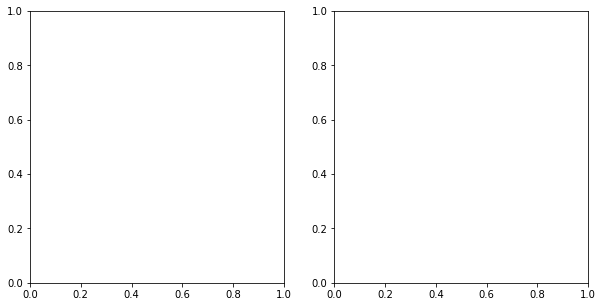

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(history.history["loss"], label="Training loss")
ax[0].plot(history.history["val_loss"], label="Validation loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot Dice and IoU
ax[1].plot(history.history["Dice"], label="Training Dice")
ax[1].plot(history.history["val_Dice"], label="Validation Dice")
ax[1].plot(history.history["IoU"], label="Training IoU")
ax[1].plot(history.history["val_IoU"], label="Validation IoU")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Dice and IoU")
ax[1].legend()

plt.show()

Plot a few examples of the training data and the predicted masks.

1/1 [==============================] - 0s 12ms/step


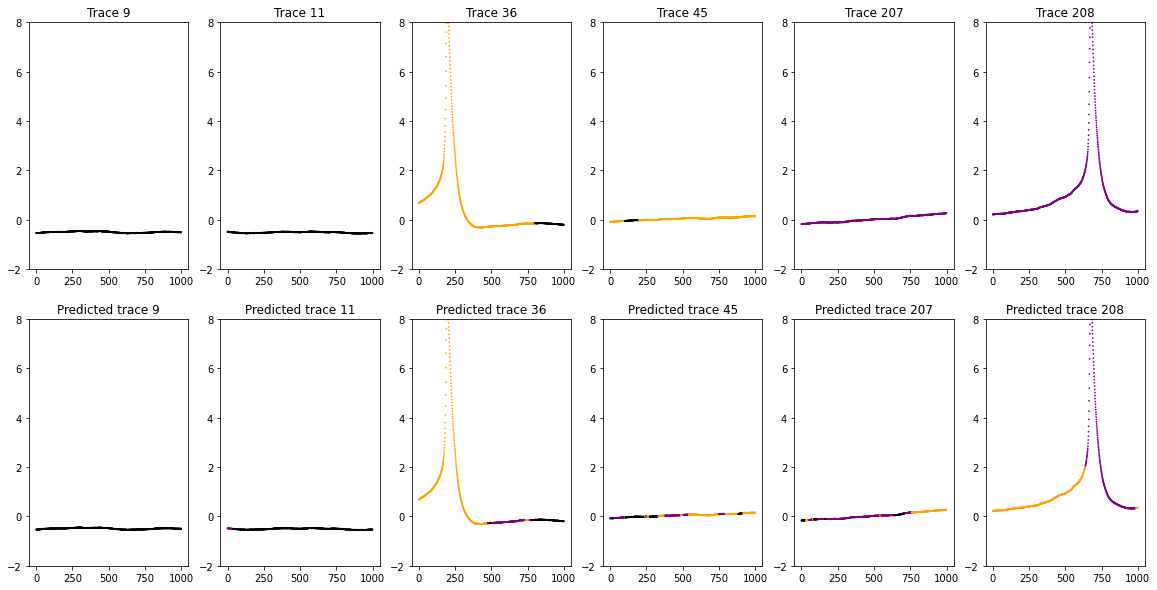

In [33]:
trace_ids = [9, 11, 36, 45, 207, 208]
cols = ["black", "orange", "purple"]

fig, ax = plt.subplots(2, len(trace_ids), figsize=(20, 10))

for i, trace in enumerate(trace_ids):
    # Plot the original trace
    c = [cols[j] for j in np.argmax(labels_val[trace], axis=1)]
    ax[0, i].scatter(range(len(traces_val[trace])), traces_val[trace], c=c, s=0.5)
    ax[0, i].set_ylim(-2, 8)
    ax[0, i].set_title(f"Trace {trace}")

    pred = model.predict(traces_val[trace].reshape(1, 1000, 1))
    
    c = [cols[j] for j in np.argmax(pred, axis=2)[0]]
    ax[1, i].scatter(range(len(traces_val[trace])), traces_val[trace], c=c, s=0.5)
    ax[1, i].set_ylim(-2, 8)
    ax[1, i].set_title(f"Predicted trace {trace}")


plt.show()


In [52]:
def predict_trace(trace: np.ndarray, model: keras.Model, threshold: float = 0.5,
                  n_points: int = 1000, offset: int = 250) -> np.ndarray:
    """
    Predict the label of a trace using the model.
    Args:
        trace: trace to predict.
        model: model to use for prediction.
        threshold: threshold to use for prediction. 
            If the probability of the class is lower than the threshold, 
            the class is set to -1 (unknown). Default is 0.5.
        n_points: number of points to use for prediction. Default is 1000.
        offset: offset to use for prediction. n_points needs to be exactly divisible by offset.
            Default is 250 (overlap of 75%).
    Returns:
        np.ndarray: Predicted labels.
    """

    assert n_points % offset == 0, f"n_points ({n_points}) needs to be exactly divisible by offset ({offset})"

    # This is the original trace length, without padding.
    # We don't need to predict any more points.
    points_to_predict = trace.shape[0]
    # Pad the trace with the last value to make it a multiple of n_points
    trace = np.pad(trace, (0, n_points - len(trace) % n_points), mode="edge")

    # Go through the trace with a step of offset and in chunks of n_points
    # We'll predict the label for each chunk, then we'll cast a majority vote
    # on the label, since we will have n_points / offset predictions for each chunk.
    # We will need to pad the ends of the trace with None labels.
    # None labels will be ignored in the vote, unless all predictions are None, in
    # which case the label will be None. At the end we'll do a nearest neighbor
    # interpolation to replace the None labels with the nearest known label.
    n_votes = n_points // offset

    # Prepare the samples to predict
    samples = np.zeros((trace.shape[0] // n_points * n_votes, n_points))

    print(samples.shape)

    for i, start in enumerate(range(0, points_to_predict, offset)):
        # Get the sample
        sample = trace[start:min(start+n_points, len(trace))]
        # If the sample is shorter than n_points, pad it with the last value
        if len(sample) < n_points:
            sample = np.pad(sample, (0, n_points - len(sample)), mode="edge")
        # Append the sample to the array
        samples[i] = sample

    # Predict the labels
    pred = model.predict(samples.reshape(-1, n_points, 1))

    # Cast the predictions to labels, unless the probability of the class is lower than the threshold
    # In that case, set the label to -1 (unknown)
    tmp_labels = np.argmax(pred, axis=2)
    # Check if any line has all probabilities lower than the threshold
    # If so, set the label to -1 (unknown)
    tmp_labels[pred.max(axis=2) < threshold] = -1

    # We will end up with n_points // offset predictions for each chunk
    # So, with the default values, we will end up with 4 predictions (1000 // 250) for each chunk
    labels = np.zeros((n_points // offset, trace.shape[0]))

    # Now rearrange the labels to match the original trace
    for i, start in enumerate(range(0, points_to_predict, offset)):
        labels[i % n_votes, start:start+n_points] = tmp_labels[i]

    # Now vote on the labels
    labels = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=labels)

    return labels[:points_to_predict]

## Test set

split_traces/test/A.txt
(404, 1000)
13/13 [==============================] - 0s 28ms/step


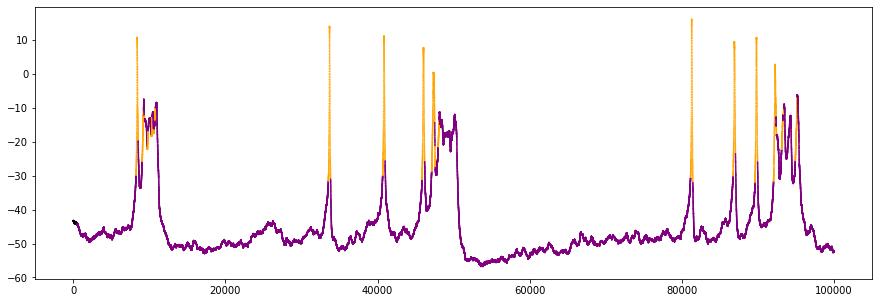

In [53]:
print(f"{traces_folder}/test/A.txt")
test_trace = pd.read_csv("full_traces/test/A.txt", sep=" ")
test_trace.columns = ["Time", "Voltage"]

labels = predict_trace(test_trace['Voltage'], model)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
cols = ["black", "orange", "purple"]
c = [cols[j] for j in labels]
ax.scatter(range(len(test_trace)), test_trace['Voltage'], c=c, s=0.2)
plt.show()

In [49]:
# [cols[j] for j in labels]

np.unique(labels, return_counts=True)

(array([0, 1, 2, 3]), array([99533,   248,     4,   216]))